In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast,
                   linear_scale_forward, log_scale_forward, UniformPrior, section_drive_param_function,
                   ConcatTensorDataset)
import multiprocessing
from typing import Dict, Tuple, Optional, List
from utils import ConcatTensorDataset
from TCN.tcn import model_TCN
import timeit

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

--No graphics will be displayed.


In [70]:
dataset_type = 'connected'
dataset_indices = list(range(900,1000))

model_dict, dataset_dict = dict(), dict()
cell_type_list = ['L5_pyramidal']
for cell_type in cell_type_list:
    cell_type_dataset = ConcatTensorDataset(
        [torch.load(f'/users/ntolley/scratch/bayesian_surrogates/datasets_{dataset_type}/training_data/{cell_type}_dataset_{idx}.pt') for
         idx in dataset_indices])
    dataset_dict[cell_type] = cell_type_dataset

    _, input_size = cell_type_dataset[0][0].detach().cpu().numpy().shape
    _, output_size = cell_type_dataset[0][1].detach().cpu().numpy().shape

    seq_len = 500
    model_dict[cell_type] = model_TCN(input_size, output_size, num_channels=[32]*3, kernel_size=20, dropout=0.2, seq_len=seq_len,
                        hidden_size=128, n_lstm_layers=3, lstm_hidden_dim=32).to(device)
    model_dict[cell_type].load_state_dict(torch.load(f'subthreshold_models/{cell_type}_subthreshold_model.pt'))
    model_dict[cell_type].to(device)

In [81]:
def run_surrogate(model, validation_set, num_neurons):
    val_data = validation_set[:1][0][:,:,:].float().to(device)

    for _ in range(num_neurons):
        with torch.no_grad():
            model.eval()
            output_sequence = model(val_data)



In [50]:
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params_base = read_params(params_fname)

def run_hnn(num_neurons_xy = 1):
    params = params_base.copy()
    params.update({'N_pyr_x': num_neurons_xy, 'N_pyr_y': num_neurons_xy})

    net = calcium_model(params=params)
    simulate_dipole(net, dt=0.5, tstop=100)

def get_hnn_neuron_num(num_neurons_xy):
    params = params_base.copy()
    params.update({'N_pyr_x': num_neurons_xy, 'N_pyr_y': num_neurons_xy})

    net = calcium_model(params=params)
    total_neurons = net.gid_ranges['L5_pyramidal'][-1] + 1
    return total_neurons
    

In [77]:
neuron_grid_array = range(1,15)
num_neuron_array = [get_hnn_neuron_num(num) for num in neuron_grid_array]

hnn_time_list = list()
for num in neuron_grid_array:
    hnn_time = timeit.timeit(lambda: run_hnn(num_neurons_xy=num), number=1)
    hnn_time_list.append(hnn_time)

/oscar/home/ntolley/Jones_Lab/bayesian_surrogates/externals/hnn-core/hnn_core/dipole.py:74: UserWarning: No external drives or biases loaded
  warnings.warn('No external drives or biases loaded', UserWarning)


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Buil

In [82]:
surrogate_time_list = list()
validation_set = dataset_dict['L5_pyramidal']
model = model_dict['L5_pyramidal']
for num in num_neuron_array:
    surrogate_time = timeit.timeit(lambda: run_surrogate(model=model, validation_set=validation_set, num_neurons=num), number=1)
    surrogate_time_list.append(surrogate_time)

Text(0, 0.5, 'Sim Time (s)')

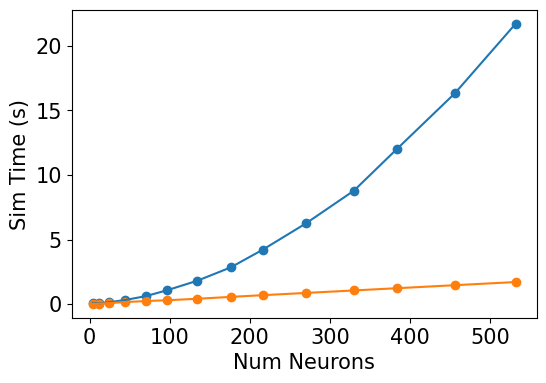

In [83]:
plt.figure(figsize=(6,4))
fontsize = 15
plt.plot(num_neuron_array, hnn_time_list)
plt.scatter(num_neuron_array, hnn_time_list)

plt.plot(num_neuron_array, surrogate_time_list)
plt.scatter(num_neuron_array, surrogate_time_list)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Num Neurons', fontsize=fontsize)
plt.ylabel('Sim Time (s)', fontsize=fontsize)

# plt.yscale('log')

